# Vehicle Detection

### Project Dependencies

In [1]:
import os
import glob
import random
from collections import deque

import cv2
import numpy as np
import pandas as pd

from scipy.misc import imread
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.externals import joblib
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from skimage.feature import hog

import matplotlib.pyplot as plt
%matplotlib inline

from moviepy.editor import VideoFileClip
from IPython.display import HTML, clear_output

### Constants

In [2]:
TEST_IMAGES_DIR = "test_images"
INPUT_VIDEOS_DIR = "input_videos"
OUTPUT_VIDEOS_DIR = "output_videos"
VEHICLES_DIR = "vehicles"
NON_VEHICLES_DIR = "non_vehicles"

### Labeled Training Data

In [3]:
car_images = glob.glob(os.path.join(VEHICLES_DIR, "*", "*.png"))
notcar_images = glob.glob(os.path.join(NON_VEHICLES_DIR, "*", "*.png"))
print("Car Images: {}".format(len(car_images)))
print("Non-car Images: {}".format(len(notcar_images)))

Car Images: 8792
Non-car Images: 8968


### Helper Functions

In [4]:
# Color map function for diagnostic visualization of the heatmap
CMAP_HOT = plt.cm.get_cmap("hot")

In [5]:
def convert_color(img, conv="RGB"):
    """
    Convert RGB color channels to a different color space
    """
    if conv == "YCrCb":
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == "HSV":
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if conv == "YUV":
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    if conv == "LUV":
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == "GRAY":
        return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return img

def create_hog_feature_extractor(orient=9, px_per_cell=8, cells_per_block=2,
                                 transform_sqrt=True, vis=False, feature_vec=False):
    """
    Factory to create HOG feature extractor with pre-determined parameters
    Computes the Histogram of Oriented Gradients feature descriptor
    If `vis=True`, return a visualization image
    """
    return lambda image: hog(image,
                             orientations=orient,
                             pixels_per_cell=(px_per_cell,px_per_cell),
                             cells_per_block=(cells_per_block,cells_per_block),
                             transform_sqrt=transform_sqrt,
                             feature_vector=feature_vec,
                             visualise=vis)

def scale_values(values):
    """
    Scale values from 0. to 1.
    """
    min_val = np.min(values)
    max_val = np.max(values)
    return (values-min_val) / (max_val-min_val)

def color_map(data):
    """
    Convert heatmap to RGB color image for diagnostic purposes
    """
    img = CMAP_HOT(scale_values(data)) * 255
    return np.clip(img[:,:,:3], 0, 255).astype(np.uint8)

def draw_bounding_rectangles(image, heatmap):
    """
    Locate bounding rectangles from a heatmap and draw them on an image
    """
    _,contours,_ = cv2.findContours(heatmap.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        x,y,w,h = cv2.boundingRect(contour)
        cv2.rectangle(image, (x, y), (x+w, y+h), (255,0,0), 6)

def evaluate_classifier(clf, X_data, y_labels, size=500, folds=5):
    """
    Perform cross validation on a classifier
    """
    scores = cross_val_score(clf, X_data[:size], y_labels[:size], cv=folds)
    accuracy = round(scores.mean(), 3)
    confidence = "+/- {:.3f}".format(scores.std() * 2)
    print("Classifier accuracy {} with confidence {}".format(accuracy, confidence))
    return accuracy, confidence

def extract_features(img_files, extractor, feature_type):
    """
    Read in a list of image files and extract salient features for training a model
    """
    features_list = []
    n_files = len(img_files)
    bar_width = 40
    for i, file_name in enumerate(img_files):
        img = imread(file_name)
        features_list.append(extractor.get_features(img, 0, img.shape[1]))
        clear_output(wait=True)
        progress = (i+1) / n_files
        prog_width = int(progress * bar_width)
        bar = "|{0:░<40}|".format("█" * prog_width)
        print("{} Extracting {} features: {:.2f}%".format(bar, feature_type, (progress * 100)))
    return features_list

def fit_model(cars, notcars, model, extractor):
    print("Extracting car features...")
    car_features = extract_features(cars, extractor, "car")
    
    print("Extracting not car features...")
    notcar_features = extract_features(notcars, extractor, "notcar")

    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    X_scaler = StandardScaler().fit(X)
    scaled_X = X_scaler.transform(X)

    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=np.random.randint(0, 100))
    
    print("Evaluating classifier with {} features...".format(len(X_train[0])))
    evaluate_classifier(model, X_train, y_train)

    print("Fitting model...")
    model.fit(X_train, y_train)

    print("Done.")
    return model, X_scaler

### Histogram of Oriented Gradients (HOG)

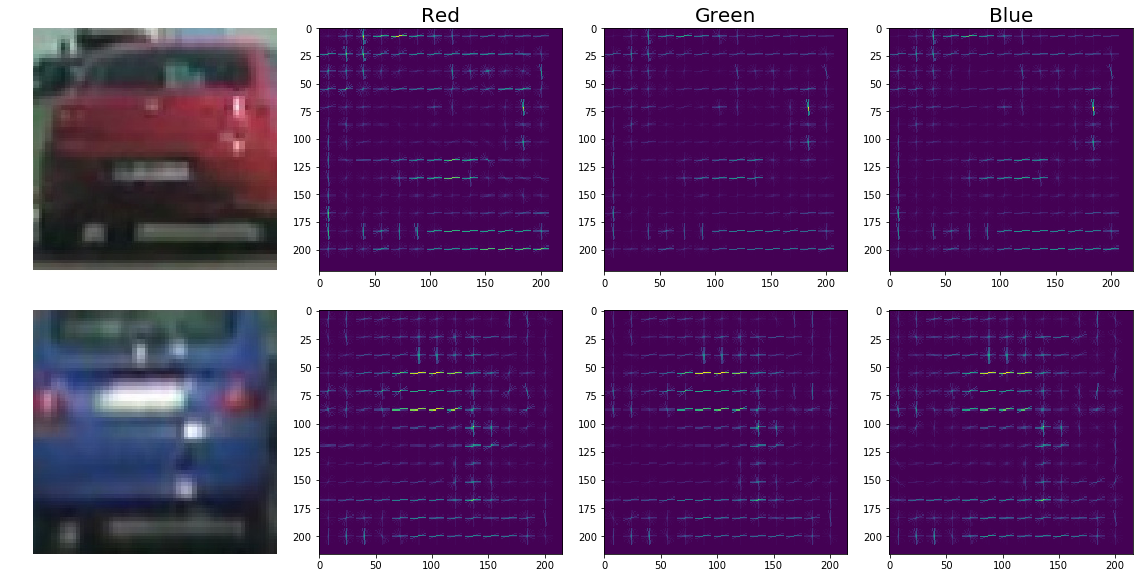

In [6]:
templist = ["cutout7.jpg", "cutout8.jpg"]

get_hog_features = create_hog_feature_extractor(orient=11, px_per_cell=16, cells_per_block=2, vis=True)

fig, axs = plt.subplots(2, 4, figsize=(16, 8))
fig.tight_layout()
for i, row in enumerate(axs):
    car_img = imread(os.path.join(TEST_IMAGES_DIR, templist[i]))
    _,hog1 = get_hog_features(car_img[:,:,0])
    _,hog2 = get_hog_features(car_img[:,:,1])
    _,hog3 = get_hog_features(car_img[:,:,2])
    ax1, ax2, ax3, ax4 = row
    ax1.axis("off")
    ax1.imshow(car_img)
    ax2.imshow(hog1)
    ax3.imshow(hog2)
    ax4.imshow(hog3)
    if i == 0:
        ax2.set_title("Red", fontsize=20)
        ax3.set_title("Green", fontsize=20)
        ax4.set_title("Blue", fontsize=20)

### Alternate Color Spaces

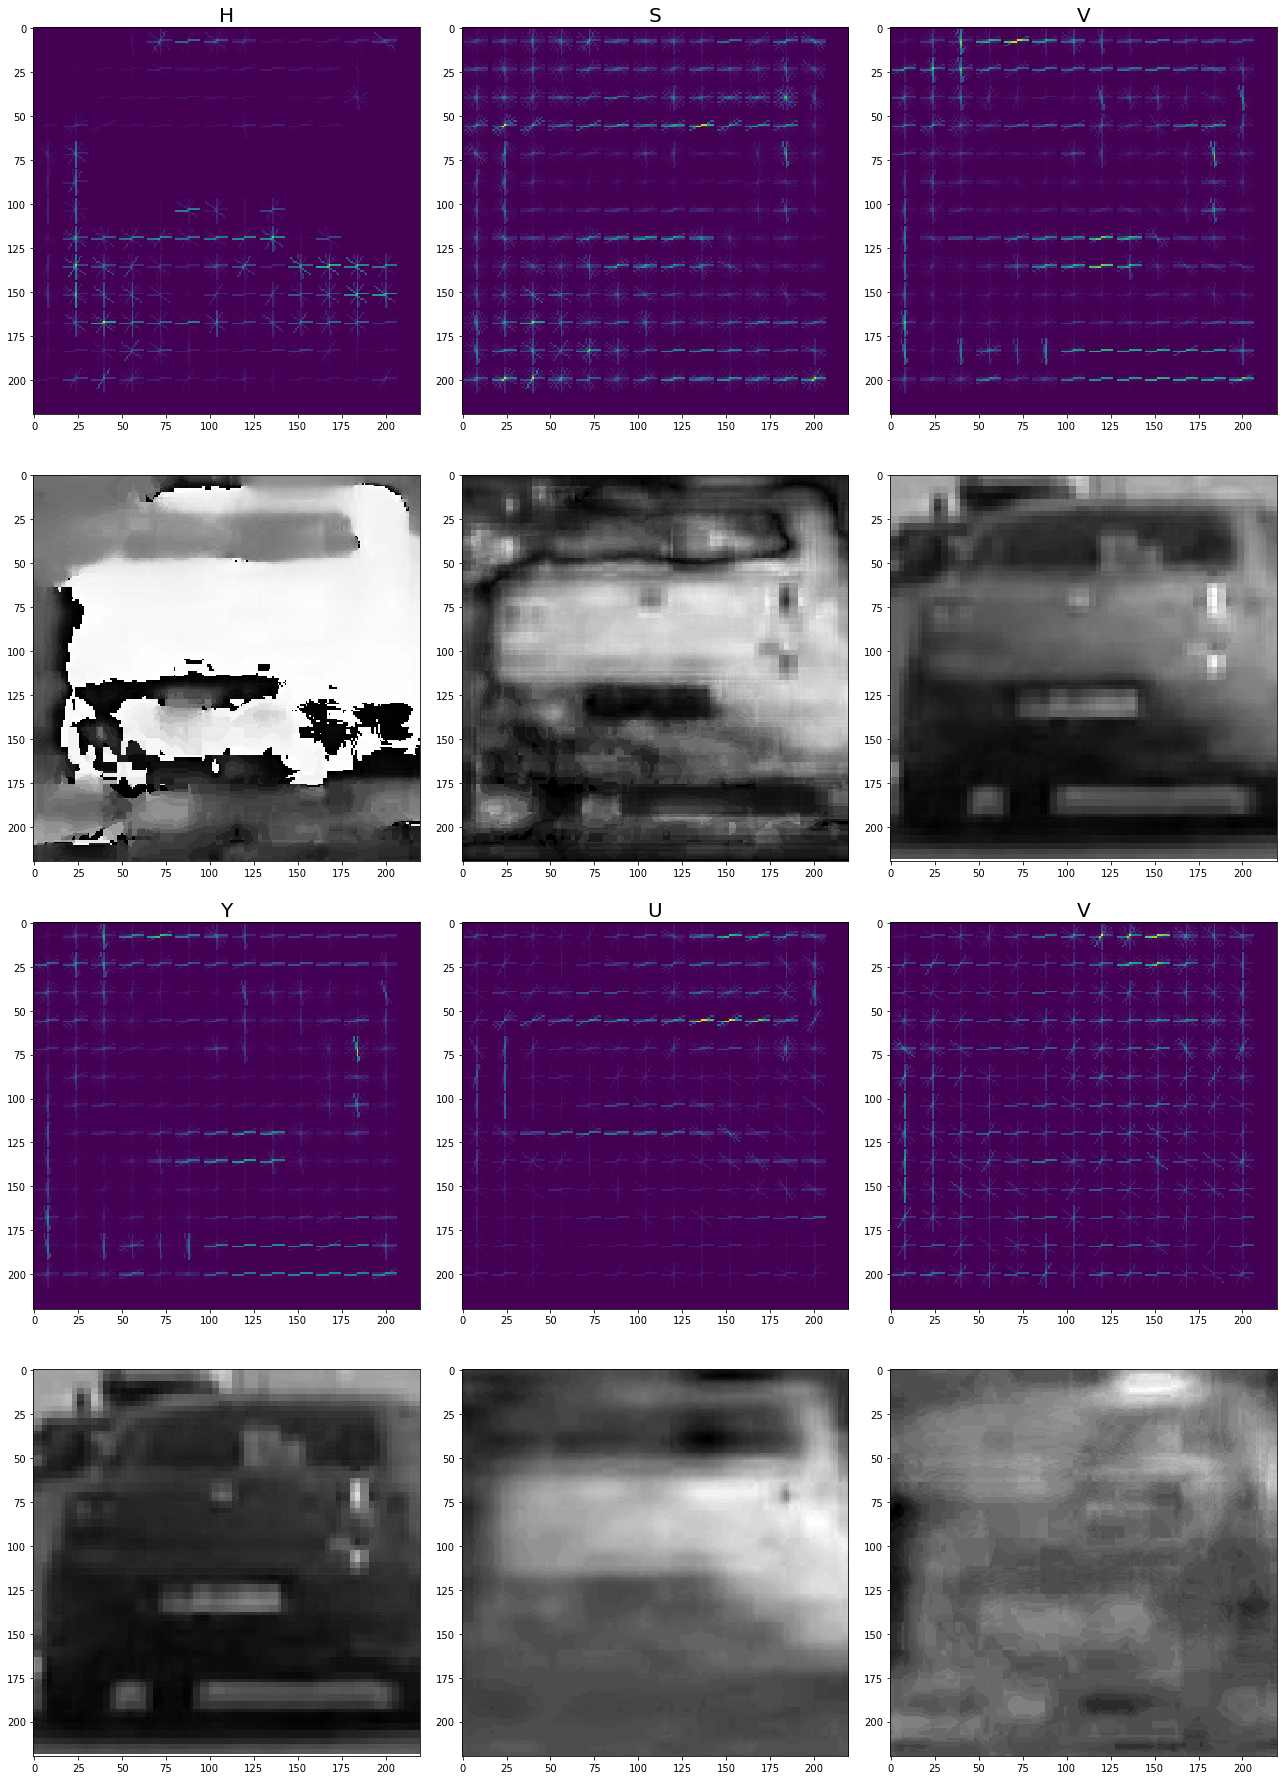

In [7]:
templist = ["cutout7.jpg"]
color_spaces = [('H','S','V'), ('Y','U','V')]

fig, axs = plt.subplots(4, 3, figsize=(18, 25))
fig.tight_layout()
for i, row in enumerate(axs):
    car_img = imread(os.path.join(TEST_IMAGES_DIR, templist[0]))
    color_space = color_spaces[i // 2]
    conv = convert_color(car_img, conv="".join(color_space))
    ax1, ax2, ax3 = row
    if i % 2 == 0:
        _,hog1 = get_hog_features(conv[:,:,0])
        _,hog2 = get_hog_features(conv[:,:,1])
        _,hog3 = get_hog_features(conv[:,:,2])
        ax1.imshow(hog1)
        ax2.imshow(hog2)
        ax3.imshow(hog3)
        ax1.set_title(color_space[0], fontsize=20)
        ax2.set_title(color_space[1], fontsize=20)
        ax3.set_title(color_space[2], fontsize=20)
    else:
        ax1.imshow(conv[:,:,0], cmap="gray")
        ax2.imshow(conv[:,:,1], cmap="gray")
        ax3.imshow(conv[:,:,2], cmap="gray")

### Feature Extractor Class

In [8]:
class FeatureExtractor:
    def __init__(self,
                 color_space="YUV",
                 orientations=9,
                 px_per_cell=16,
                 cells_per_block=2,
                 transform_sqrt=True):
        self.color_space = color_space
        self.px_per_cell = px_per_cell
        self.hog = create_hog_feature_extractor(orientations, px_per_cell, cells_per_block, transform_sqrt)

    def extract_hog_features(self, image):
        converted_img = convert_color(image, conv=self.color_space)
        self.hog1 = self.hog(converted_img[:,:,0])
        self.hog2 = self.hog(converted_img[:,:,1])
        self.hog3 = self.hog(converted_img[:,:,2])
    
    def get_hog_slice(self, x_start_px, size_px):
        x_start_hog, x_end_hog = self.hog_coords(x_start_px, size_px)
        hog_features1 = self.hog1[:, x_start_hog:x_end_hog].ravel()
        hog_features2 = self.hog2[:, x_start_hog:x_end_hog].ravel()
        hog_features3 = self.hog3[:, x_start_hog:x_end_hog].ravel()
        return np.hstack((hog_features1, hog_features2, hog_features3))

    def hog_coords(self, x_start_px, size_px):
        size_hog = size_px // self.px_per_cell
        x_start_hog = x_start_px // self.px_per_cell
        x_end_hog = x_start_hog + size_hog - 1
        return x_start_hog, x_end_hog
    
    def get_features(self, image, x_start, size):
        self.extract_hog_features(image)
        return self.get_hog_slice(x_start, size)

### Exploring HOG Parameters

In [9]:
svc_linear = LinearSVC()

df = pd.DataFrame(columns=["orientations", "px_per_cell", "accuracy", "conf", "n features"])

index = 0
for i in range(8,14):
    for j in range(11,17):
        print("Orientations: {}; Px Per Cell: {};".format(i,j))
        # initiate the extractor class with the desired
        extractor = FeatureExtractor(color_space="YUV",
                                     orientations=i,
                                     px_per_cell=j,
                                     cells_per_block=2)

        sample_size = 1000

        print("{}: Extracting car features...".format(index))
        car_features = extract_features(random.sample(car_images, sample_size), extractor, "car")

        print("{}: Extracting not car features...".format(index))
        notcar_features = extract_features(random.sample(notcar_images, sample_size), extractor, "notcar")

        X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
        X_scaler = StandardScaler().fit(X)
        scaled_X = X_scaler.transform(X)

        y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

        X_train, X_test, y_train, y_test = train_test_split(
            scaled_X, y, test_size=0.2, random_state=np.random.randint(0, 100))

        print("Evaluating classifier with {} features...".format(len(X_train[0])))
        accuracy, confidence = evaluate_classifier(svc_linear, X_train, y_train)
        
        df.loc[index] = i, j, accuracy, confidence, len(X_train[0])
        index += 1

print(df.sort_values(["accuracy"], ascending=False))

|████████████████████████████████████████| Extracting notcar features: 100.00%
Evaluating classifier with 1404 features...
Classifier accuracy 0.97 with confidence +/- 0.046
    orientations  px_per_cell  accuracy       conf  n features
1            8.0         12.0     0.986  +/- 0.020      1536.0
23          11.0         16.0     0.982  +/- 0.026      1188.0
29          12.0         16.0     0.978  +/- 0.015      1296.0
25          12.0         12.0     0.976  +/- 0.020      2304.0
34          13.0         15.0     0.974  +/- 0.016      1404.0
4            8.0         15.0     0.974  +/- 0.020       864.0
24          12.0         11.0     0.972  +/- 0.029      2304.0
28          12.0         15.0     0.972  +/- 0.026      1296.0
17          10.0         16.0     0.970  +/- 0.025      1080.0
35          13.0         16.0     0.970  +/- 0.046      1404.0
33          13.0         14.0     0.970  +/- 0.033      1404.0
5            8.0         16.0     0.970  +/- 0.022       864.0
13     

### Training the Model

In [10]:
svc_linear = LinearSVC()
ml_perceptron = MLPClassifier()

# initiate the extractor class with the desired parameters
extractor = FeatureExtractor(color_space="YUV",
                             orientations=9,
                             px_per_cell=16,
                             cells_per_block=2)

model, scaler = fit_model(car_images,
                          notcar_images,
                          ml_perceptron,
                          extractor)

# Save trained model and scaler
print("Model saved to", joblib.dump(model, "model_mlp.pkl"))
print("Scaler saved to", joblib.dump(scaler, "scaler_mlp.pkl"))

|████████████████████████████████████████| Extracting notcar features: 100.00%
Evaluating classifier with 972 features...
Classifier accuracy 0.96 with confidence +/- 0.065
Fitting model...
Done.
Model saved to ['model_mlp.pkl']
Scaler saved to ['scaler_mlp.pkl']


### Classifier Class

In [11]:
class Classifier:
    def __init__(self, model, scaler, threshold=.99):
        self.model = model
        self.scaler = scaler
        self.threshold = threshold

    def is_car(self, X):
        scaled_X = self.scaler.transform(X)
        prediction = self.model.predict_proba(scaled_X)
        return prediction[0,1] > self.threshold

### Sliding Windows

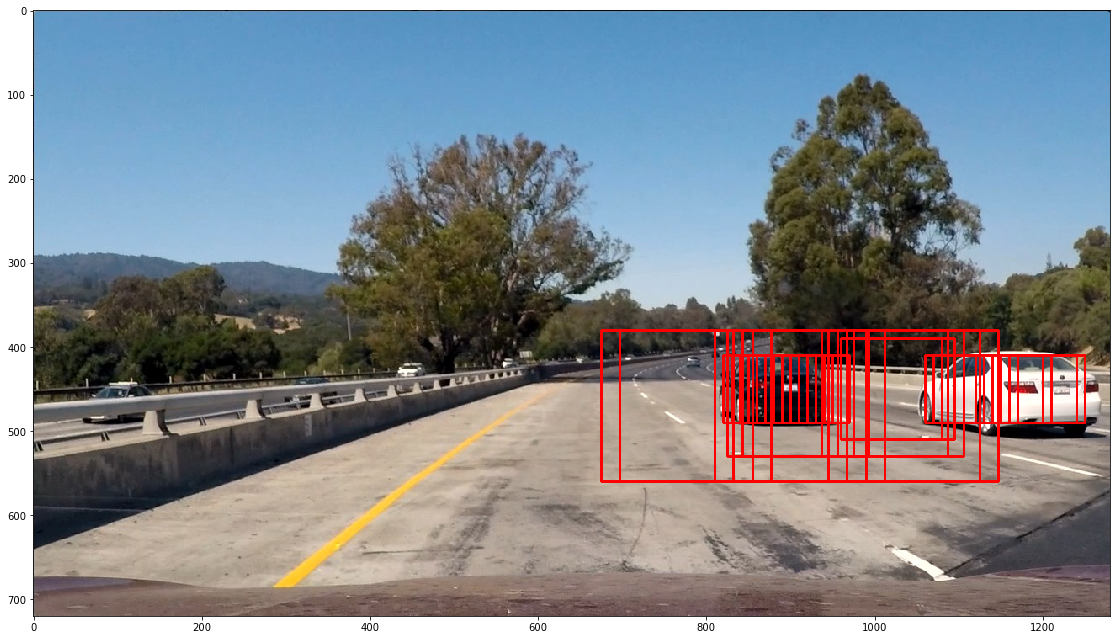

In [12]:
window_positions = (410, 390, 380, 380)
window_sizes = (80, 120, 150, 180)
step_size = 8
base_size = 64

model = joblib.load("model_mlp.pkl")
scaler = joblib.load("scaler_mlp.pkl")

classifier = Classifier(model, scaler, threshold=.98)

fig, ax = plt.subplots(1, 1, figsize=(18, 9))
fig.tight_layout()

image = imread(os.path.join(TEST_IMAGES_DIR, "test{}.jpg".format(1)))
extractor = FeatureExtractor()

for y_top, win_size in zip(window_positions, window_sizes):
    scale = win_size / base_size
    width = int(image.shape[1] / scale)

    y_bottom = y_top + win_size
    search_strip = cv2.resize(image[y_top:y_bottom], (width,base_size))
    extractor.extract_hog_features(search_strip)
    x_end = (width // base_size-1) * base_size
    for x_left in range(0, x_end, step_size):
        features = extractor.get_hog_slice(x_left, base_size)
        x_left = int(scale * x_left)
        x_right = x_left + win_size
        if classifier.is_car(features):
            cv2.rectangle(image, (x_left,y_top), (x_right,y_bottom), (255,0,0), 2)

ax.imshow(image)

### Window Slider Class

In [13]:
class WindowSlider:
    def __init__(self, extractor, classifier, window_size=64, step_size=8):
        self.extractor = extractor
        self.classifier = classifier
        self.step_size = step_size
        self.size = window_size

    def find_cars(self, image, heatmap, y_top, win_size):
        scale = win_size / self.size
        width = int(image.shape[1] / scale)

        y_bottom = y_top + win_size
        search_strip = cv2.resize(image[y_top:y_bottom], (width,self.size))
        self.extractor.extract_hog_features(search_strip)

        x_end = (width // self.size-1) * self.size
        for x_left in range(0, x_end, self.step_size):
            features = self.extractor.get_hog_slice(x_left, self.size)
            if self.classifier.is_car(features):
                x_left = int(scale * x_left)
                x_right = x_left + win_size
                heatmap[y_top:y_bottom, x_left:x_right] += 1

### Initiating Classifier and Window Slider

In [16]:
model = joblib.load("model_mlp.pkl")
scaler = joblib.load("scaler_mlp.pkl")

classifier = Classifier(model, scaler, threshold=.98)

window_slider = WindowSlider(extractor,
                             classifier,
                             window_size=64,
                             step_size=8)

### Heatmap

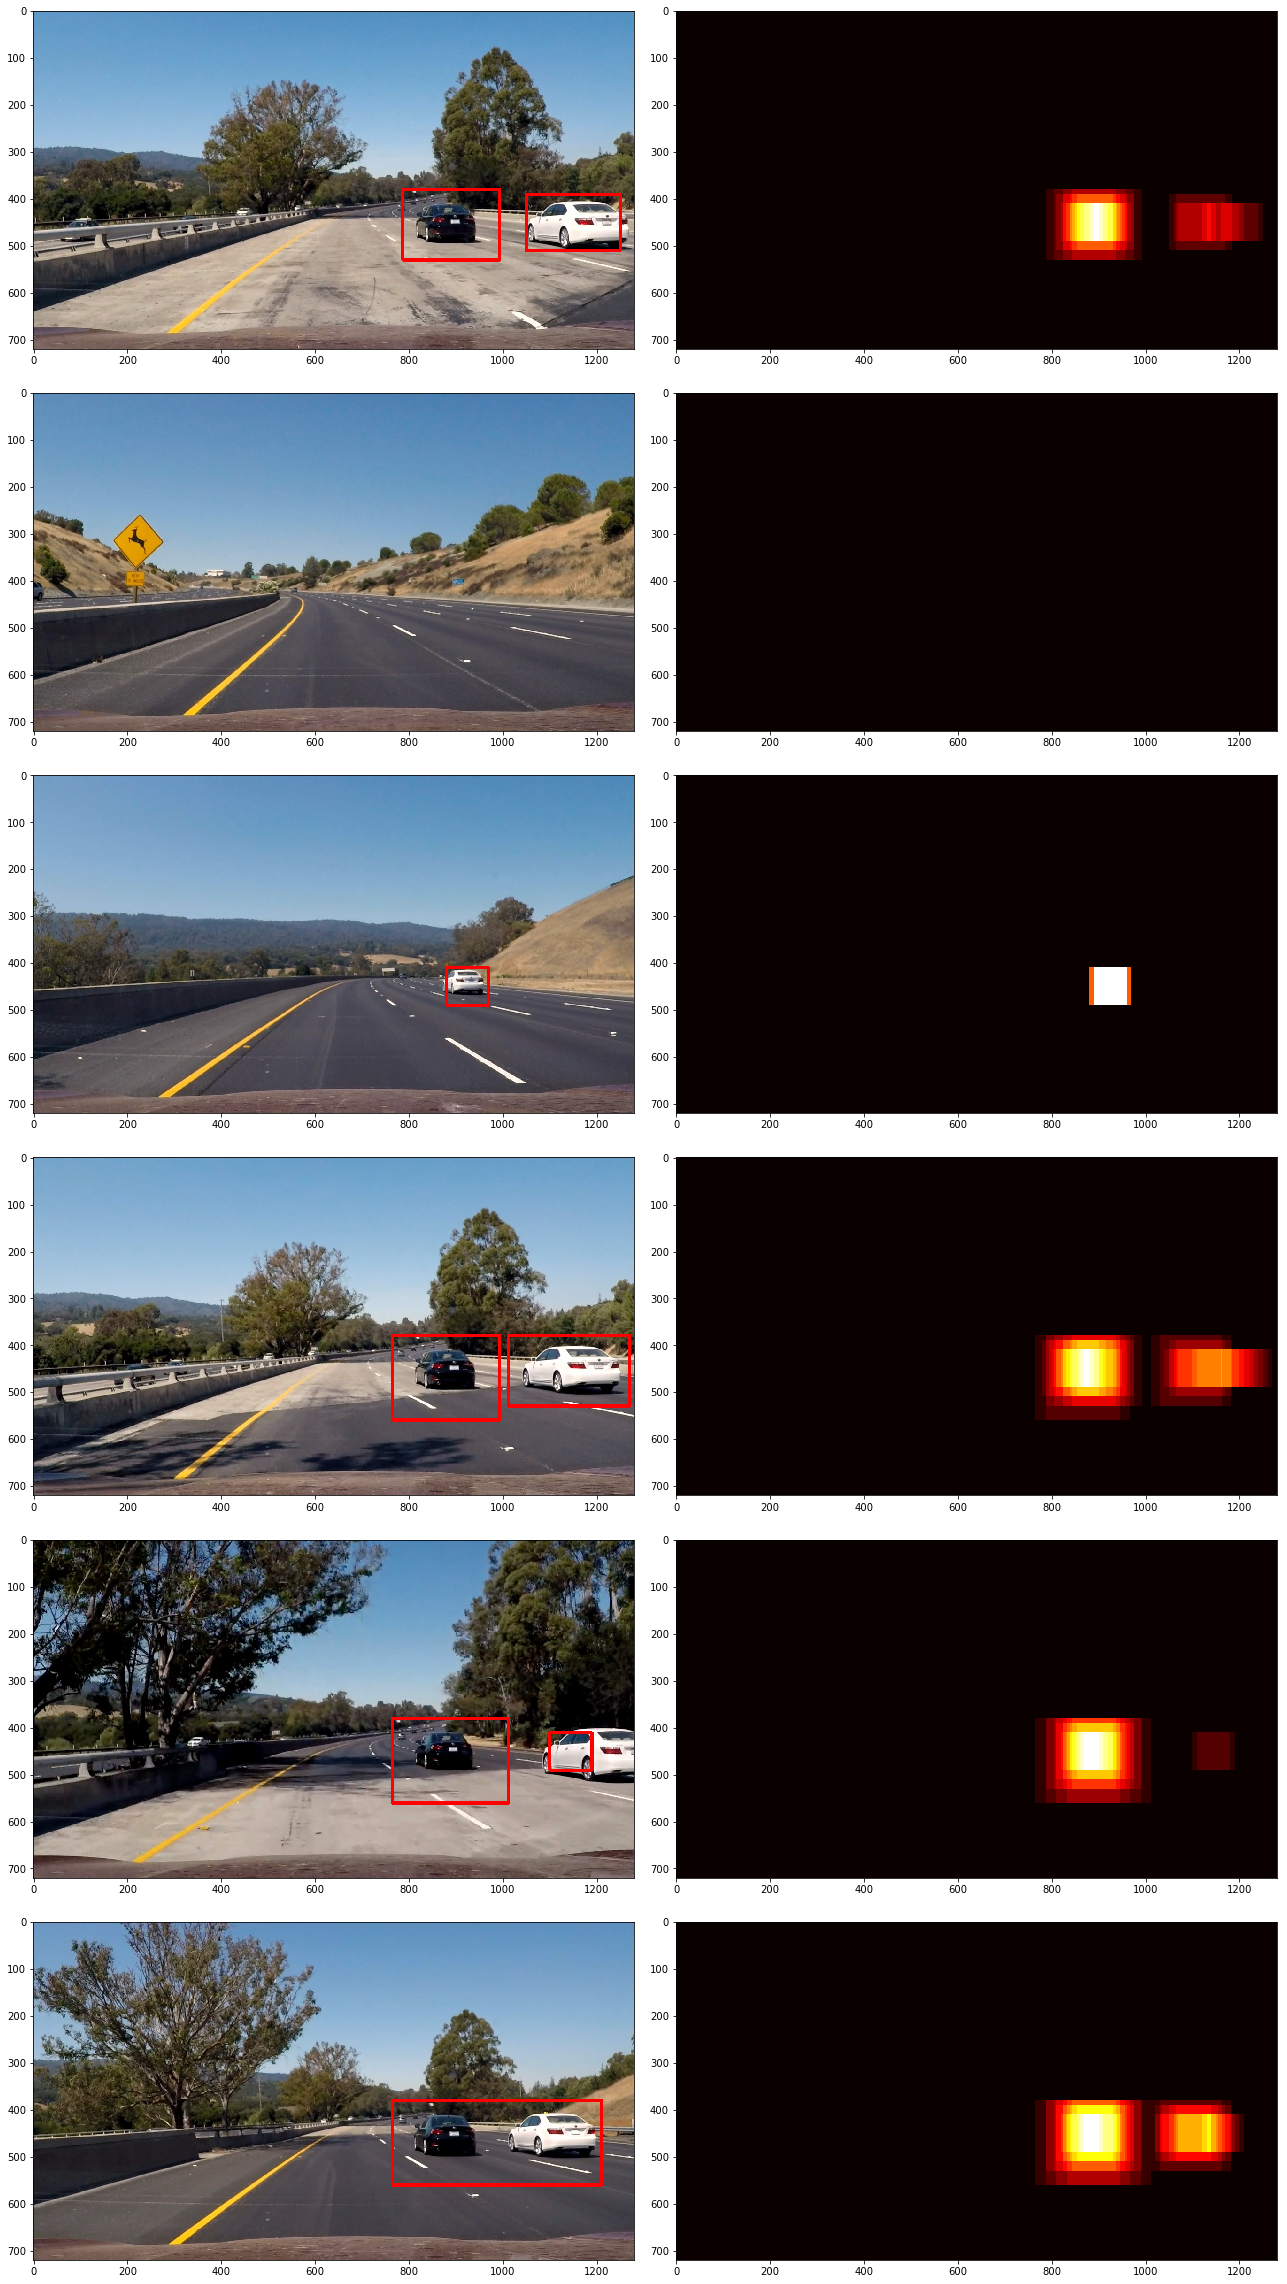

In [17]:
window_positions = (410, 390, 380, 380)
window_sizes = (80, 120, 150, 180)

fig, axs = plt.subplots(6, 2, figsize=(18, 32))
fig.tight_layout()
for i, row in enumerate(axs):
    ax1, ax2 = row
    image = imread(os.path.join(TEST_IMAGES_DIR, "test{}.jpg".format(i+1)))

    heatmap = np.zeros_like(image[:,:,0])
    for y_top, win_size in zip(window_positions, window_sizes):
        window_slider.find_cars(image, heatmap, y_top, win_size)

    draw_bounding_rectangles(image, heatmap)

    ax1.imshow(image)
    ax2.imshow(color_map(heatmap))

### Pipeline

In [18]:
def process_frame(image):
    heatmap = np.zeros_like(image[:,:,0])
    for y_top, win_size in zip(window_positions, window_sizes):
        window_slider.find_cars(image, heatmap, y_top, win_size)
    buffer.append(heatmap)
    heatmap = np.sum(buffer, axis=0)
    heatmap[heatmap < threshold] = 0
    draw_bounding_rectangles(image, heatmap.astype(np.uint8))

    if SHOW_DIAGNOSTIC:
        image = cv2.addWeighted(image, 1, color_map(heatmap), 0.5, 0)
    return image

In [26]:
SHOW_DIAGNOSTIC = True
n_frames = 10
threshold = 15
buffer = deque(maxlen=n_frames)
project_output = os.path.join(OUTPUT_VIDEOS_DIR, "project_video_diagnostic.mp4")
clip1 = VideoFileClip(os.path.join(INPUT_VIDEOS_DIR, "project_video.mp4"))
white_clip = clip1.fl_image(process_frame) 
%time white_clip.write_videofile(project_output, audio = False)

[MoviePy] >>>> Building video output_videos/project_video_diagnostic.mp4
[MoviePy] Writing video output_videos/project_video_diagnostic.mp4


100%|█████████▉| 1260/1261 [05:12<00:00,  3.78it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video_diagnostic.mp4 

CPU times: user 4min 24s, sys: 45.9 s, total: 5min 10s
Wall time: 5min 13s


In [27]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))